Group Members: Bolong Tang, Siddanth Singh, Molly Du, Hung Dang

Exploratory Data Analysis

Initial Analysis of Wind Speeds Over Time: Slight Negative Correlation But Not Significant

<Figure size 1200x600 with 0 Axes>

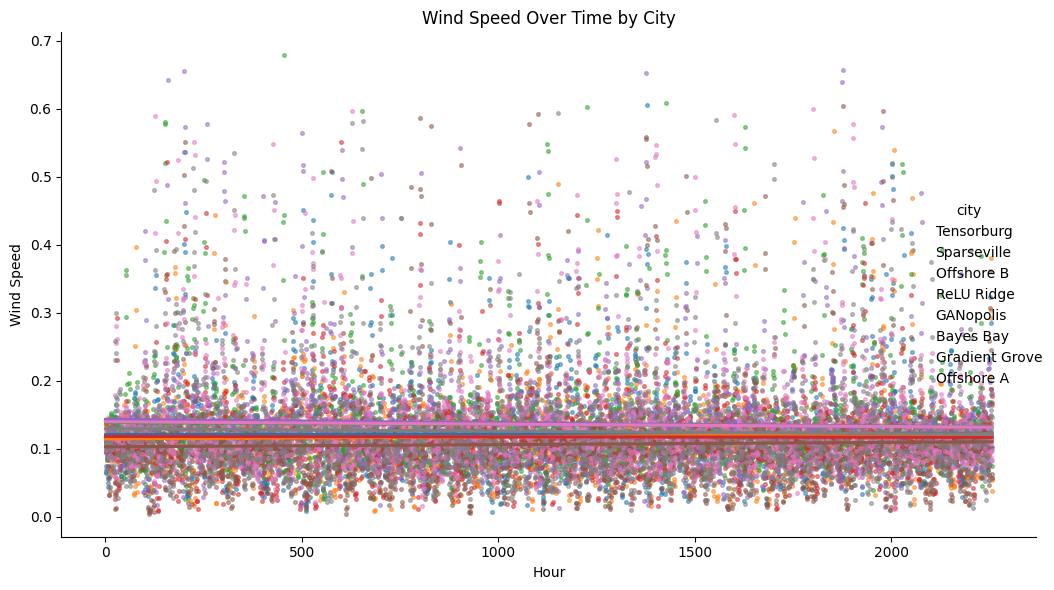

<Figure size 1200x600 with 0 Axes>

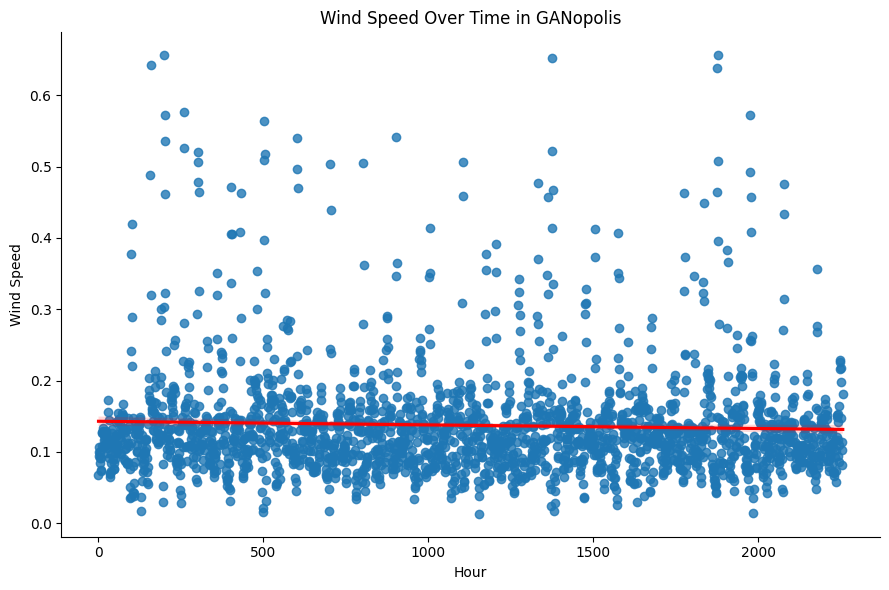

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_allcities = pd.read_csv("training_data.csv")
df_ganopolis = df_allcities[df_allcities["city"] == "GANopolis"]

df_byhour = df_allcities.groupby(['city','hour'])['windspeed'].mean().reset_index()

# Scatterplot with linear regression of the entire data grouped by city
plt.figure(figsize=(12, 6))
sns.lmplot(x='hour', y='windspeed', hue='city', data=df_allcities, aspect=1.5, height=6, scatter_kws={'s':7, 'alpha':0.5})
plt.title('Wind Speed Over Time by City')
plt.xlabel('Hour')
plt.ylabel('Wind Speed')
plt.tight_layout()
plt.show()

# Scatterplot with linear regression of GANopolis
plt.figure(figsize=(12, 6))
sns.lmplot(x='hour', y='windspeed', data=df_ganopolis, aspect=1.5, height=6, line_kws={'color': 'red'})
plt.title('Wind Speed Over Time in GANopolis')
plt.xlabel('Hour')
plt.ylabel('Wind Speed')
plt.tight_layout()
plt.show()

Correlation Matrix Findings: velocity_x (inversely correlated) and damages (directly correlated) are the most highly correlated for both the general dataset and GANopolis specifically

Correlation Matrix for All Cities:
             pressure  air_temp  ground_temp  velocity_x  velocity_y  \
pressure     1.000000  0.010464     0.046918    0.028755    0.002752   
air_temp     0.010464  1.000000     0.967284    0.041425   -0.006766   
ground_temp  0.046918  0.967284     1.000000    0.036805    0.016794   
velocity_x   0.028755  0.041425     0.036805    1.000000   -0.052788   
velocity_y   0.002752 -0.006766     0.016794   -0.052788    1.000000   
windspeed   -0.363606 -0.009855    -0.071175   -0.528449   -0.025765   
damage      -0.085545 -0.000754    -0.018956   -0.008600    0.007835   

             windspeed    damage  
pressure     -0.363606 -0.085545  
air_temp     -0.009855 -0.000754  
ground_temp  -0.071175 -0.018956  
velocity_x   -0.528449 -0.008600  
velocity_y   -0.025765  0.007835  
windspeed     1.000000  0.272116  
damage        0.272116  1.000000  

Correlation Matrix for GANopolis:
             pressure  air_temp  ground_temp  velocity_x  velocity_y  \
p

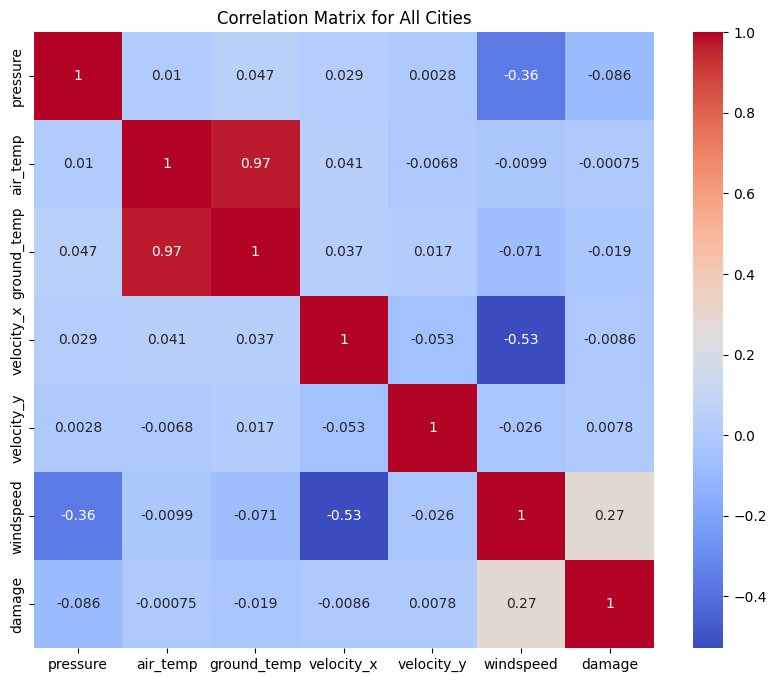

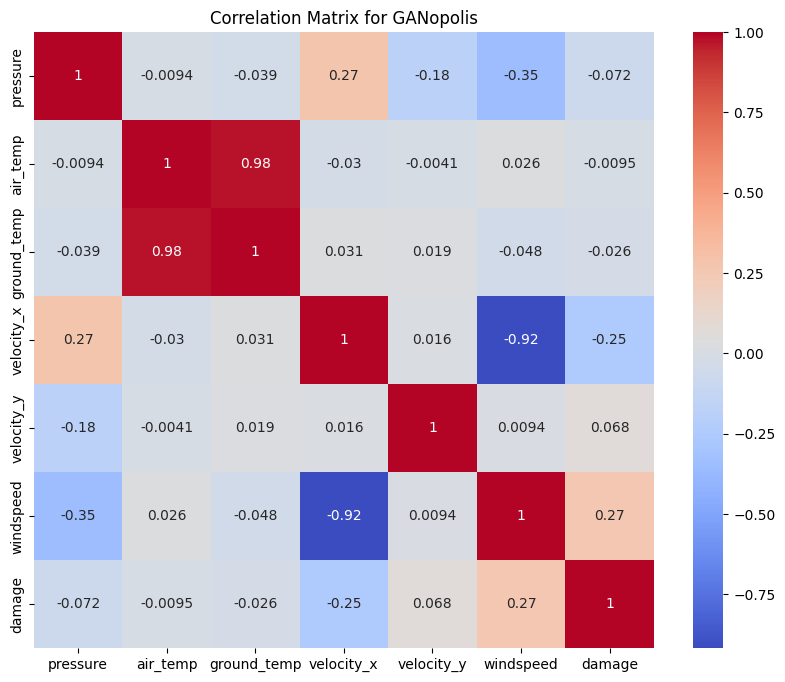

In [58]:
columns_to_include = [col for col in df_allcities.columns if col not in ['hour', 'day', 'hour_of_day', 'city']]

# Produce correlation matrices
correlation_matrix_allcities = df_allcities[columns_to_include].corr()
correlation_matrix_ganopolis = df_ganopolis[columns_to_include].corr()

print("Correlation Matrix for All Cities:")
print(correlation_matrix_allcities)

print("\nCorrelation Matrix for GANopolis:")
print(correlation_matrix_ganopolis)

# Visualize correlation matrices
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_allcities, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for All Cities')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_ganopolis, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for GANopolis')
plt.show()


Generation of PCA analysis visualizations further exemplify this fact.

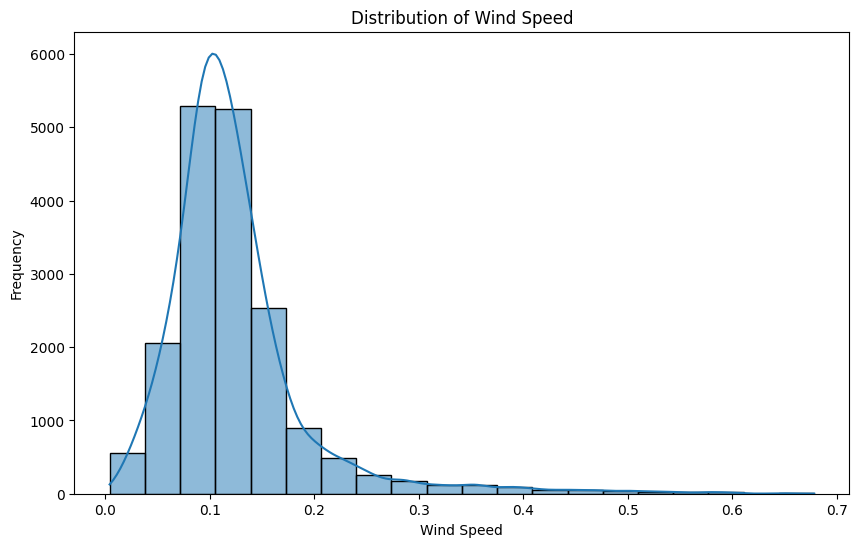

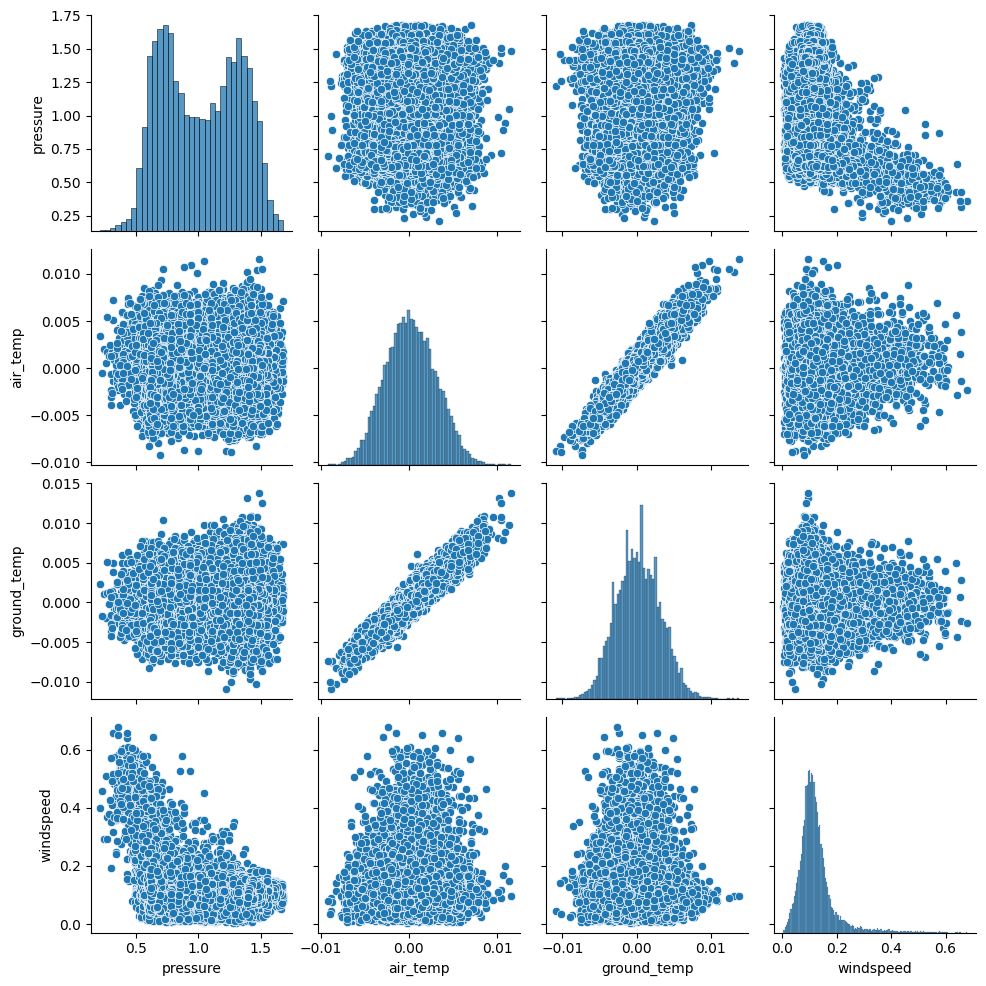

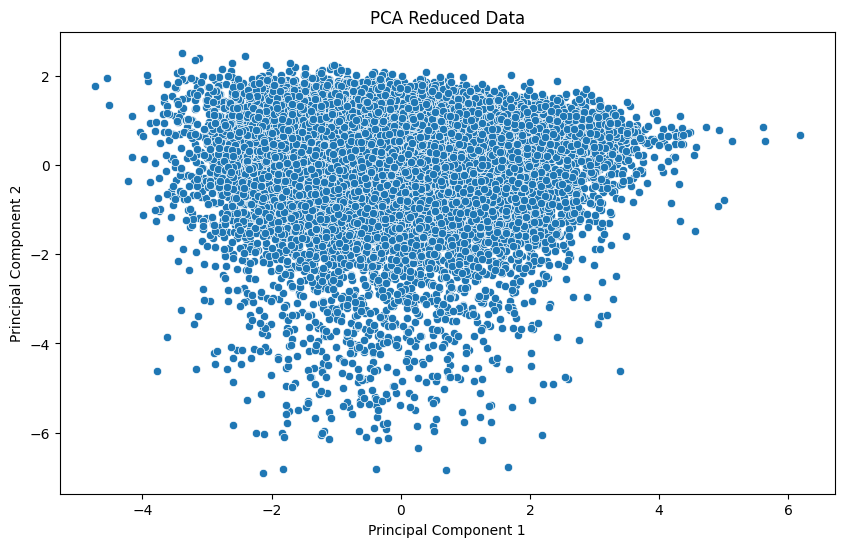

In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.figure(figsize=(10, 6))
sns.histplot(df_allcities['windspeed'], bins=20, kde=True)
plt.title('Distribution of Wind Speed')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

# Multivariable Analysis
sns.pairplot(df_allcities[['pressure', 'air_temp', 'ground_temp', 'windspeed']])
plt.show()

# Applying PCA Dimensionality Reduction
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_allcities[['pressure', 'air_temp', 'ground_temp', 'windspeed']])
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1])
plt.title('PCA Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

XGBoost Training Using a 70/30 train/test split

In [60]:
# Generation of training and test sets from the training data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df_allcities.dropna(inplace=True)
features = ['velocity_x', 'damage']
X = df_allcities[features]
y = df_allcities['windspeed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# XGBoost Training
xgb_model = XGBRegressor(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

xgb_train_score = xgb_model.score(X_train, y_train)
xgb_test_score = xgb_model.score(X_test, y_test)

print(f"XGBoost Training Score: {xgb_train_score}")
print(f"XGBoost Test Score: {xgb_test_score}")

XGBoost Training Score: 0.9937785533236976
XGBoost Test Score: 0.991233792636497


Visualize the Accuracy in the XGBoost Test Score

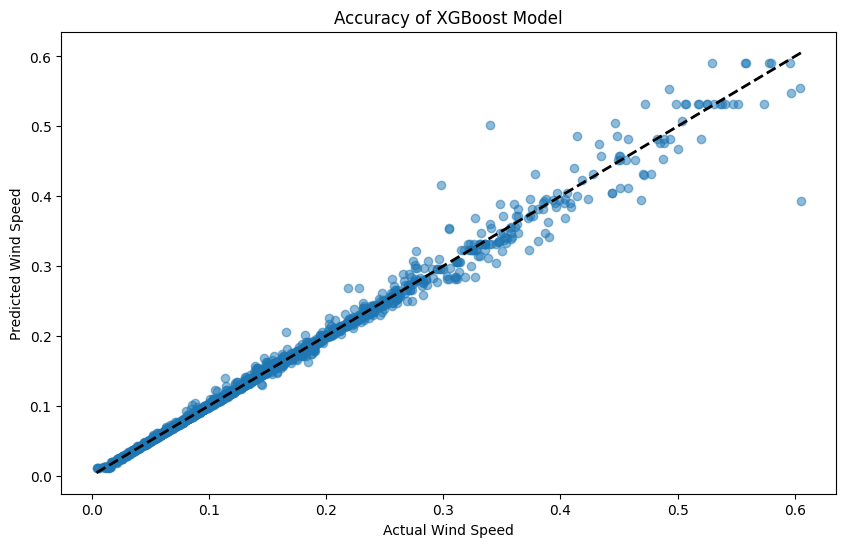

In [61]:
# Accuracy Scatterplot between Actual Test Data and Predicted Test Data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual Wind Speed')
plt.ylabel('Predicted Wind Speed')
plt.title('Accuracy of XGBoost Model')
plt.show()

Predicting windspeed data for the next five days for events 1-10. Using time-series makes this possible

In [63]:
results = []

for event_id in range(1, 11):
    df_event = pd.read_csv(f"event_{event_id}.csv")

    df_event['lag_1'] = df_event['windspeed'].shift(1)
    df_event['lag_2'] = df_event['windspeed'].shift(2)
    df_event = df_event[df_event['city'] == 'GANopolis']

    X = df_event[['damage', 'velocity_x', 'lag_1', 'lag_2']]
    y = df_event['windspeed']

    # Train model
    model = XGBRegressor(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1)
    model.fit(X, y)

    # Predict next 120 points
    predictions = model.predict(X.tail(120))

    row = [event_id, ""] + list(predictions)  # Empty string for blank price column
    results.append(row)

    df_event['windspeed'] = model.predict(X)
    df_event.to_csv(f"event_{event_id}.csv", index=False)

# Create consolidated DataFrame
column_names = ['event_number', 'price'] + [str(i) for i in range(120)]
df_results = pd.DataFrame(results, columns=column_names)

# Save consolidated CSV
df_results.to_csv("consolidated_predictions.csv", index=False)